# Experiment 10

This experiment aims to test the effect of the number of agents on the performance of the swarm. The number of agents is varied from 10 to 100 in steps of 10. The number of turns is fixed at 100.

In [17]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx

import logging

from src.simulation import Simulation
from src.network import Network
from src.render import Render

logging.disable(logging.CRITICAL)

In [2]:
network_file_1 = "networks/Net3.inp"
network_file_2 = "networks/250701 K709vs2-Export.inp"
network_file_3 = "networks/Net6.inp"

env1 = Network(network_file_1)
env2 = Network(network_file_2)
env3 = Network(network_file_3)

g_env1 = env1.water_network_model.to_graph().to_undirected()
g_env2 = env2.water_network_model.to_graph().to_undirected()
g_env3 = env3.water_network_model.to_graph().to_undirected()

d_env1 = g_env1.degree
d_env2 = g_env2.degree
d_env3 = g_env3.degree

env1_start_pool = [node for node, degree in d_env1 if degree == 1]
env2_start_pool = [node for node, degree in d_env2 if degree == 1]
env3_start_pool = [node for node, degree in d_env3 if degree == 1]

env1_num_links = env1.graph_num_links
env2_num_links = env2.graph_num_links
env3_num_links = env3.graph_num_links

print("Start Pool - Net3: ", env1_start_pool)
print("Number of Start Nodes - Net3: ", len(env1_start_pool))
print("Number of Nodes - Net3: ", env1.graph_num_nodes)
print("Number of Links - Net3: ", env1.graph_num_links)

print("Start Pool - 250701 K709vs2-Export: ", env2_start_pool)
print("Number of Start Nodes - 250701 K709vs2-Export: ", len(env2_start_pool))
print("Number of Nodes - 250701 K709vs2-Export: ", env2.graph_num_nodes)
print("Number of Links - 250701 K709vs2-Export: ", env2.graph_num_links)

print("Start Pool - Net6: ", env3_start_pool)
print("Number of Start Nodes - Net6: ", len(env3_start_pool))
print("Number of Nodes - Net6: ", env3.graph_num_nodes)
print("Number of Links - Net6: ", env3.graph_num_links)

Start Pool - Net3:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2', '3']
Number of Start Nodes - Net3:  16
Number of Nodes - Net3:  97
Number of Links - Net3:  119
Start Pool - 250701 K709vs2-Export:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187', 'A5189', 'A5191', 'A5197', 'A5200', 'A5202', 'A5205', 'A5245', 'A5247', 'A5255', 'A5271', 'A5279', 'A5283', 'A5285', 'A5306', 'A5311', 'A5323', 'A5342', 'A5343', 'A5348', 'A5351', 'A5354', 'A5357', 'A5376', 'A5377', 'A5379', 'A5383', 'A5387', 'A5390', 'A5391', 'A5394', 'A5396', 'A5398', 'A5400', 'A5404', 'A5407', 'A5408', 'A5412', 'A5423', 'A5424', 'A5426', 'A5428', 'A5430', 'A5431', 'A5435', 'A5440', 'A5448', 'A5450', 'A5451', 'A5460', 'A5462', 'A5471', 'A5473', 'A5474', 'A5480', 'A5481', 'A5485', 'A5502', 'A5510', 'A5513', 'A5515', 'A5701', 'A5708', 'AN-1871', 'N-0457', 'N-0458', 'N-0459', 'N-0460',

In [3]:
def run_simulation_batch(env, num_agents, start_nodes, filepath, max_turns=100):
    print("Starting Simulation Batch - ", filepath)
    print("Number of Agents: ", num_agents)
    print("Start Nodes: ", start_nodes)
    print("Max Turns: ", max_turns)

    root_path = f'{filepath}/NoSwarm'
    simulations_1 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting No Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=False, start_positions=[node], filepath=path)
            simulations_1.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_1
    
    root_path = f'{filepath}/NaiveSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'naive'}
    simulations_2 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Naive Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_2.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_2
    
    root_path = f'{filepath}/InformedMeanSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'mean'}
    simulations_3 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Informed Mean Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_3.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_3
    
    root_path = f'{filepath}/InformedMedianSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'median'}
    simulations_4 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Informed Median Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_4.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns)
    yield simulations_4

## Simulations

### Simulation 1 - Environment 1

In [4]:
start_nodes = env1_start_pool[:15]
num_agents = [i for i in range(10, 110, 10)]
max_turns = 100
filepath = "notable-results/Experiment-10/Env1"

print("Start Nodes: ", start_nodes)
print("Number of Agents: ", num_agents)

Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [5]:
simulations_10_1 = run_simulation_batch(env1, num_agents, start_nodes, filepath, max_turns=max_turns)

In [6]:
no_swarm_env1 = next(simulations_10_1)

Starting Simulation Batch -  notable-results/Experiment-10/Env1
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Max Turns:  100
Starting No Swarm Simulation from Start Node: 15; 10 agents
Starting No Swarm Simulation from Start Node: 35; 10 agents
Starting No Swarm Simulation from Start Node: 131; 10 agents
Starting No Swarm Simulation from Start Node: 166; 10 agents
Starting No Swarm Simulation from Start Node: 167; 10 agents
Starting No Swarm Simulation from Start Node: 203; 10 agents
Starting No Swarm Simulation from Start Node: 219; 10 agents
Starting No Swarm Simulation from Start Node: 225; 10 agents
Starting No Swarm Simulation from Start Node: 231; 10 agents
Starting No Swarm Simulation from Start Node: 243; 10 agents
Starting No Swarm Simulation from Start Node: 253; 10 agents
Starting No Swarm Simulation from Start Node: River; 10 agents
Starting N

In [7]:
naive_swarm_env1 = next(simulations_10_1)

Starting Naive Swarm Simulation from Start Node: 15; 10 agents
Starting Naive Swarm Simulation from Start Node: 35; 10 agents
Starting Naive Swarm Simulation from Start Node: 131; 10 agents
Starting Naive Swarm Simulation from Start Node: 166; 10 agents
Starting Naive Swarm Simulation from Start Node: 167; 10 agents
Starting Naive Swarm Simulation from Start Node: 203; 10 agents
Starting Naive Swarm Simulation from Start Node: 219; 10 agents
Starting Naive Swarm Simulation from Start Node: 225; 10 agents
Starting Naive Swarm Simulation from Start Node: 231; 10 agents
Starting Naive Swarm Simulation from Start Node: 243; 10 agents
Starting Naive Swarm Simulation from Start Node: 253; 10 agents
Starting Naive Swarm Simulation from Start Node: River; 10 agents
Starting Naive Swarm Simulation from Start Node: Lake; 10 agents
Starting Naive Swarm Simulation from Start Node: 1; 10 agents
Starting Naive Swarm Simulation from Start Node: 2; 10 agents
Starting Naive Swarm Simulation from Start 

In [8]:
informed_mean_swarm_env1 = next(simulations_10_1)

Starting Informed Mean Swarm Simulation from Start Node: 15; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 35; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 131; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 166; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 167; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 203; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 219; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 225; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 231; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 243; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 253; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: River; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: Lake; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 1; 10 

In [9]:
informed_median_swarm_env1 = next(simulations_10_1)

Starting Informed Median Swarm Simulation from Start Node: 15; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 35; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 131; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 166; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 167; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 203; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 219; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 225; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 231; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 243; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 253; 10 agents
Starting Informed Median Swarm Simulation from Start Node: River; 10 agents
Starting Informed Median Swarm Simulation from Start Node: Lake; 10 agents
Starting Informed Median Swarm Simula

### Simulation 2 - Environment 2

In [66]:
start_nodes = env2_start_pool[:15]
num_agents = [i for i in range(10, 110, 10)]
max_turns = 100
filepath = "notable-results/Experiment-10/Env2"

print("Start Nodes: ", start_nodes)
print("Number of Agents: ", num_agents)

Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [67]:
simulations_10_2 = run_simulation_batch(env2, num_agents, start_nodes, filepath, max_turns=max_turns)

In [68]:
no_swarm_env2 = next(simulations_10_2)

Starting Simulation Batch -  notable-results/Experiment-10/Env2
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Max Turns:  100
Starting No Swarm Simulation from Start Node: A2148; 10 agents
Starting No Swarm Simulation from Start Node: A3007; 10 agents
Starting No Swarm Simulation from Start Node: A3018; 10 agents
Starting No Swarm Simulation from Start Node: A5065; 10 agents
Starting No Swarm Simulation from Start Node: A5071; 10 agents
Starting No Swarm Simulation from Start Node: A5078; 10 agents
Starting No Swarm Simulation from Start Node: A5153; 10 agents
Starting No Swarm Simulation from Start Node: A5169; 10 agents
Starting No Swarm Simulation from Start Node: A5174; 10 agents
Starting No Swarm Simulation from Start Node: A5175; 10 agents
Starting No Swarm Simulation from Start Node: A5178; 10 agents
Starting No Swar

In [69]:
naive_swarm_env2 = next(simulations_10_2)

Starting Naive Swarm Simulation from Start Node: A2148; 10 agents
Starting Naive Swarm Simulation from Start Node: A3007; 10 agents
Starting Naive Swarm Simulation from Start Node: A3018; 10 agents
Starting Naive Swarm Simulation from Start Node: A5065; 10 agents
Starting Naive Swarm Simulation from Start Node: A5071; 10 agents
Starting Naive Swarm Simulation from Start Node: A5078; 10 agents
Starting Naive Swarm Simulation from Start Node: A5153; 10 agents
Starting Naive Swarm Simulation from Start Node: A5169; 10 agents
Starting Naive Swarm Simulation from Start Node: A5174; 10 agents
Starting Naive Swarm Simulation from Start Node: A5175; 10 agents
Starting Naive Swarm Simulation from Start Node: A5178; 10 agents
Starting Naive Swarm Simulation from Start Node: A5183; 10 agents
Starting Naive Swarm Simulation from Start Node: A5184; 10 agents
Starting Naive Swarm Simulation from Start Node: A5185; 10 agents
Starting Naive Swarm Simulation from Start Node: A5187; 10 agents
Starting N

In [70]:
informed_mean_swarm_env2 = next(simulations_10_2)

Starting Informed Mean Swarm Simulation from Start Node: A2148; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A3007; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A3018; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5065; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5071; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5078; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5153; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5169; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5174; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5175; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5178; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5183; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5184; 10 agents
Starting Informed Mean Swarm Simulatio

In [71]:
informed_median_swarm_env2 = next(simulations_10_2)

Starting Informed Median Swarm Simulation from Start Node: A2148; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A3007; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A3018; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5065; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5071; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5078; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5153; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5169; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5174; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5175; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5178; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5183; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5184; 10 agents
Starting Inf

## Analysis

In [11]:
from typing import List

# Read the results from the simulations
def read_results(simulations, swarm_type) -> List[pd.DataFrame]:
    results = []
    for sim in simulations:
        start_node, num_agents, path = sim
        df = pd.read_csv(f"{path}/results.csv")
        df['start_node'] = start_node
        df.start_node = start_node
        df['num_agents'] = num_agents
        df.num_agents = num_agents
        df['swarm_type'] = swarm_type
        df.swarm_type = swarm_type
        results.append(df)
    return results

In [87]:
no_res_env1 = read_results(no_swarm_env1, 'no-swarm')
naive_res_env1 = read_results(naive_swarm_env1, 'naive')
imean_res_env1 = read_results(informed_mean_swarm_env1, 'informed-mean')
imed_res_env1 = read_results(informed_median_swarm_env1, 'informed-median')
results_env1 = pd.concat([pd.concat(no_res_env1), pd.concat(naive_res_env1), pd.concat(imean_res_env1), pd.concat(imed_res_env1)])

In [88]:
no_res_env2 = read_results(no_swarm_env2, 'no-swarm')
naive_res_env2 = read_results(naive_swarm_env2, 'naive')
imean_res_env2 = read_results(informed_mean_swarm_env2, 'informed-mean')
imed_res_env2 = read_results(informed_median_swarm_env2, 'informed-median')
results_env2 = pd.concat([pd.concat(no_res_env2), pd.concat(naive_res_env2), pd.concat(imean_res_env2), pd.concat(imed_res_env2)])

In [75]:
assert len(results_env1) == max_turns * len(start_nodes) * len(num_agents) * 4
assert len(results_env2) == max_turns * len(start_nodes) * len(num_agents) * 4

### Descriptive Statistics and Graphs

In [89]:
# For each swarm type and number of agents, get the average number of links explored across all start nodes
def get_avg_links_explored(results, swarm_type, num_agents):
    swarm_type_results = results[results.swarm_type == swarm_type]
    swarm_type_results = swarm_type_results[swarm_type_results.num_agents == num_agents]
    return swarm_type_results.abs_links_explored.mean()

# Create a dataframe with the average number of links explored for each swarm type and number of agents
def get_avg_links_explored_df(results):
    swarm_types = results.swarm_type.unique()
    num_agents = results.num_agents.unique()
    avg_links_explored = []
    for swarm_type in swarm_types:
        for num_agent in num_agents:
            avg_links_explored.append(get_avg_links_explored(results, swarm_type, num_agent))
    return pd.DataFrame({'swarm_type': np.repeat(swarm_types, len(num_agents)), 'num_agents': np.tile(num_agents, len(swarm_types)), 'avg_links_explored': avg_links_explored})

# Create a pivot table with the average number of links explored for each swarm type and number of agents
def get_avg_links_explored_pivot(results):
    return get_avg_links_explored_df(results).pivot(index='num_agents', columns='swarm_type', values='avg_links_explored')

In [90]:
# Create a dataframe with the average number of links explored for each swarm type and number of agents
avg_links_explored_env1 = get_avg_links_explored_df(results_env1)

In [91]:
# Create a pivot table with the average number of links explored for each swarm type and number of agents
avg_links_explored_pivot_env1 = get_avg_links_explored_pivot(results_env1)
avg_links_explored_pivot_env1

swarm_type,informed-mean,informed-median,naive,no-swarm
num_agents,,,,
10,67.298667,67.298667,56.875333,29.151333
20,83.936667,83.936667,67.397333,29.151333
30,88.389333,88.389333,71.040667,29.151333
40,89.360000,89.360000,70.640000,29.151333
50,89.830000,89.830000,74.656000,29.151333
60,90.323333,90.323333,74.269333,29.151333
70,90.674667,90.673333,78.366667,29.151333
80,90.757333,90.757333,78.088667,29.151333
90,90.757333,90.757333,80.032000,29.151333


In [152]:
informed = avg_links_explored_pivot_env1['informed-mean'].to_numpy()
naive = avg_links_explored_pivot_env1['naive'].to_numpy()
no_swarm = avg_links_explored_pivot_env1['no-swarm'].to_numpy()

anova_flag = True

stat, p = stats.levene(informed, naive)
print('Levene\'s test:')
print(' stat=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Probably the same distribution')
    anova_flag = anova_flag and True
else:
    print('Probably different distributions')
    anova_flag = anova_flag and False
    
stat, p = stats.shapiro(informed)
print('Informed group normality test:')
print('  p-value:', p)

if p > 0.05:
    print('Probably normal')
    anova_flag = anova_flag and True
else:
    print('Probably not normal')
    anova_flag = anova_flag and False

stat, p = stats.shapiro(naive)
print('Naive group normality test:')
print('  p-value:', p)

if p > 0.05:
    print('Probably normal')
    anova_flag = anova_flag and True
else:
    print('Probably not normal')
    anova_flag = anova_flag and False
    
print()
print("-----------------------------")

if anova_flag is False:
    print('Performing Kruskal-Wallis test')
    stat, p = stats.kruskal(informed, naive)
    print(' stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
        print('There is no significant difference between the number of links explored for informed and naive swarm')
    else:
        print('Probably different distributions')
        print('There is a significant difference between the median number of links explored for informed and naive swarm')
        print('What does this mean? - The median mean number of links explored for informed swarm is', np.median(informed), 'and for naive swarm is', np.median(naive))
        print('Informed tends to explore more links than naive swarm at multiple number of agents')
else:
    print('Performing ANOVA test')
    stat, p = stats.f_oneway(informed, naive)
    print(' stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
        
    else:
        print('Probably different distributions')
        

Levene's test:
 stat=0.365, p=0.553
Probably the same distribution
Informed group normality test:
  p-value: 1.8675060346140526e-05
Probably not normal
Naive group normality test:
  p-value: 0.10015872865915298
Probably normal

-----------------------------
Performing Kruskal-Wallis test
 stat=9.635, p=0.002
Probably different distributions
There is a significant difference between the median number of links explored for informed and naive swarm
What does this mean? - The median mean number of links explored for informed swarm is 90.07666666666667 and for naive swarm is 74.46266666666668
Informed tends to explore more links than naive swarm at multiple number of agents


In [92]:
# Create a dataframe with the average number of links explored for each swarm type and number of agents
avg_links_explored_env2 = get_avg_links_explored_df(results_env2)

In [93]:
# Create a pivot table with the average number of links explored for each swarm type and number of agents
avg_links_explored_pivot_env2 = get_avg_links_explored_pivot(results_env2)
avg_links_explored_pivot_env2

swarm_type,informed-mean,informed-median,naive,no-swarm
num_agents,,,,
10,92.112000,92.112000,74.135333,33.377333
20,122.730667,122.730667,84.030000,33.377333
30,134.277333,134.277333,91.582000,33.377333
40,136.730667,136.730667,100.484000,33.377333
50,140.914000,140.914000,107.652667,33.377333
60,145.432000,145.436667,119.986000,33.377333
70,151.617333,151.617333,117.083333,33.377333
80,153.054667,153.054667,117.006667,33.377333
90,154.736667,154.736667,116.584000,33.377333


#### Graphs

In [94]:
swarm_type_to_linestyle = {
    'no-swarm': 'solid',
    'naive': 'dashed',
    'informed-mean': 'dotted',
    'informed-median': 'dashdot'
}

# Create a scatter plot of the average number of links explored for each swarm type and number of agents
def plot_avg_links_explored(results, title:str):
    swarm_types = results.swarm_type.unique()
    num_agents = results.num_agents.unique()
    for swarm_type in swarm_types:
        swarm_type_results = results[results.swarm_type == swarm_type]
        plt.plot(swarm_type_results.num_agents, swarm_type_results.avg_links_explored, label=swarm_type, linestyle=swarm_type_to_linestyle[swarm_type])
    plt.xlabel('Number of Agents')
    plt.ylabel('Average Links Explored')
    plt.title(title)
    plt.legend()
    plt.show()

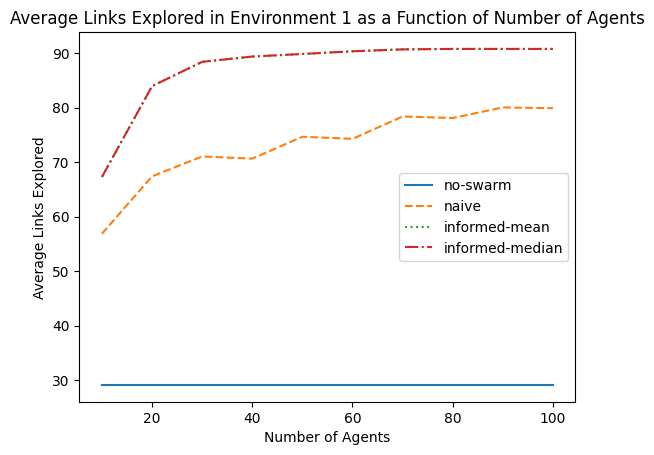

In [95]:
# Create a scatter plot of the average number of links explored for each swarm type and number of agents
plot_avg_links_explored(avg_links_explored_env1, 'Average Links Explored in Environment 1 as a Function of Number of Agents')

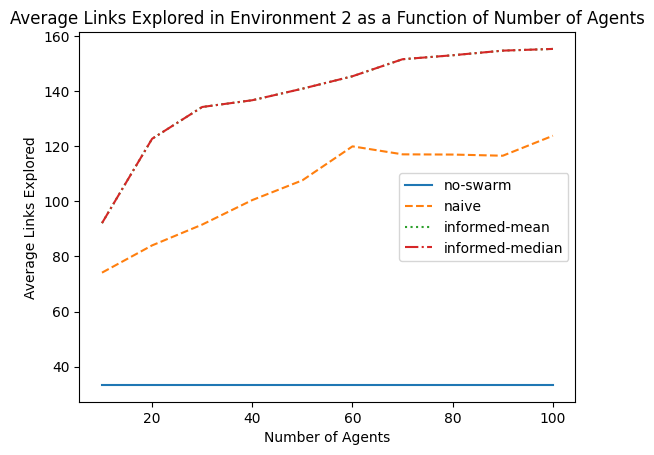

In [96]:
# Create a scatter plot of the average number of links explored for each swarm type and number of agents
plot_avg_links_explored(avg_links_explored_env2, 'Average Links Explored in Environment 2 as a Function of Number of Agents')

### Linear Regression

Null hypothesis: The number of agents has no effect on the performance of the swarm.

#### Environment 1

In [154]:
avg_links_explored_env1.sample(10)

,swarm_type,num_agents,avg_links_explored
30,informed-median,10,67.298667
10,naive,10,56.875333
23,informed-mean,40,89.360000
0,no-swarm,10,29.151333
21,informed-mean,20,83.936667
15,naive,60,74.269333
18,naive,90,80.032000
5,no-swarm,60,29.151333
28,informed-mean,90,90.757333
3,no-swarm,40,29.151333


In [175]:
informed_mean = avg_links_explored_env1[avg_links_explored_env1.swarm_type == 'informed-mean']
informed_median = avg_links_explored_env1[avg_links_explored_env1.swarm_type == 'informed-median']
naive = avg_links_explored_env1[avg_links_explored_env1.swarm_type == 'naive']
no_swarm = avg_links_explored_env1[avg_links_explored_env1.swarm_type == 'no-swarm']

##### No Swarm

In [180]:
no_swarm_model = sm.formula.ols(formula='avg_links_explored ~ num_agents', data=no_swarm).fit()
no_swarm_model.summary()

/home/swizzle/University/MECH3895/PipeSwarmSim/env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     avg_links_explored   R-squared:                      -5.500
Model:                            OLS   Adj. R-squared:                 -6.312
Method:                 Least Squares   F-statistic:                    -6.769
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               1.00
Time:                        16:11:19   Log-Likelihood:                 309.16
No. Observations:                  10   AIC:                            -614.3
Df Residuals:                       8   BIC:                            -613.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.1513   6.92e-15   4.21e+15      0.000      29.151      29.151
num_agents  2.776e-16   1.11e-16      2.489      0.038    2.05e-17    5.35e-16
==============================================================================
Omnibus:                        0.760   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.583
Skew:                          -0.127   Prob(JB):                        0.747
Kurtosis:                       1.845   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Naive Swarm

In [181]:
naive_model = sm.formula.ols(formula='avg_links_explored ~ num_agents', data=naive).fit()
naive_model.summary()

/home/swizzle/University/MECH3895/PipeSwarmSim/env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     avg_links_explored   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     39.00
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           0.000247
Time:                        16:11:31   Log-Likelihood:                -24.442
No. Observations:                  10   AIC:                             52.88
Df Residuals:                       8   BIC:                             53.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.3391      2.129     28.807      0.000      56.429      66.249
num_agents     0.2143      0.034      6.245      0.000       0.135       0.293
==============================================================================
Omnibus:                        5.779   Durbin-Watson:                   1.335
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                2.281
Skew:                          -1.133   Prob(JB):                        0.320
Kurtosis:                       3.579   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Informed (mean) Swarm

In [182]:
informed_model = sm.formula.ols(formula='avg_links_explored ~ num_agents', data=informed).fit()
informed_model.summary()

/home/swizzle/University/MECH3895/PipeSwarmSim/env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     avg_links_explored   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     7.339
Date:                Fri, 07 Apr 2023   Prob (F-statistic):             0.0267
Time:                        16:11:39   Log-Likelihood:                -30.285
No. Observations:                  10   AIC:                             64.57
Df Residuals:                       8   BIC:                             65.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.0368      3.819     20.431      0.000      69.229      86.844
num_agents     0.1668      0.062      2.709      0.027       0.025       0.309
==============================================================================
Omnibus:                        8.245   Durbin-Watson:                   0.980
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                3.409
Skew:                          -1.326   Prob(JB):                        0.182
Kurtosis:                       4.071   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Informed (median) Swarm

In [183]:
informed_mean_model = sm.formula.ols(formula='avg_links_explored ~ num_agents', data=informed_mean).fit()
informed_mean_model.summary()

/home/swizzle/University/MECH3895/PipeSwarmSim/env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     avg_links_explored   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     7.339
Date:                Fri, 07 Apr 2023   Prob (F-statistic):             0.0267
Time:                        16:11:44   Log-Likelihood:                -30.285
No. Observations:                  10   AIC:                             64.57
Df Residuals:                       8   BIC:                             65.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.0368      3.819     20.431      0.000      69.229      86.844
num_agents     0.1668      0.062      2.709      0.027       0.025       0.309
==============================================================================
Omnibus:                        8.245   Durbin-Watson:                   0.980
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                3.409
Skew:                          -1.326   Prob(JB):                        0.182
Kurtosis:                       4.071   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""